In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# global temperature anomalies and SOI with nino34 anomalies
df = pd.read_csv("global_soi.csv") 
df = df.dropna(subset=['nino34_anom'])
# df = df[['anom', 'SOI', 'nino34_anom']]

In [3]:
# SST with SOI and nino anomalies
df_2 = pd.read_csv("sst_soi.csv") 
df_2 = df_2.dropna(subset=['nino34_anom'])
# df_2 = df_2[['SST', 'SOI', 'nino34_anom']]

In [4]:
df

,Date,anom,SOI,nino34_anom
0,1975-01-01,-0.501454,-0.8,-0.45
1,1975-02-01,-0.713925,1.3,-0.68
2,1975-03-01,-1.061828,2.6,-1.09
3,1975-04-01,-0.831106,1.9,-0.96
4,1975-05-01,-1.017528,1.1,-1.13
...,...,...,...,...
595,2024-08-01,-0.079800,1.5,-0.12
596,2024-09-01,-0.303431,-0.2,-0.26
597,2024-10-01,-0.251793,0.8,-0.27
598,2024-11-01,-0.198918,0.8,-0.25


In [5]:
df_2

,Date,SST,SOI,nino34_anom
0,1975-01-01,25.909142,-0.8,-0.45
1,1975-02-01,26.124323,1.3,-0.68
2,1975-03-01,26.501217,2.6,-1.09
3,1975-04-01,26.896011,1.9,-0.96
4,1975-05-01,26.821934,1.1,-1.13
...,...,...,...,...
595,2024-08-01,26.686146,1.5,-0.12
596,2024-09-01,26.407278,-0.2,-0.26
597,2024-10-01,26.364750,0.8,-0.27
598,2024-11-01,26.541756,0.8,-0.25


In [6]:
merge_anom = pd.merge(df, df_2, on='Date',how='inner')

In [7]:
merge_anom = merge_anom[['Date', 'anom', 'SOI_x', 'nino34_anom_x','SST']]

In [8]:
merge_anom.rename(columns={'nino34_anom_x': 'nino34_anom'}, inplace=True)
merge_anom.rename(columns={'SOI_x': 'SOI'}, inplace=True)
merge_anom.rename(columns={'anom': 'g_anom'}, inplace=True)

In [9]:
merge_anom

,Date,g_anom,SOI,nino34_anom,SST
0,1975-01-01,-0.501454,-0.8,-0.45,25.909142
1,1975-02-01,-0.713925,1.3,-0.68,26.124323
2,1975-03-01,-1.061828,2.6,-1.09,26.501217
3,1975-04-01,-0.831106,1.9,-0.96,26.896011
4,1975-05-01,-1.017528,1.1,-1.13,26.821934
...,...,...,...,...,...
595,2024-08-01,-0.079800,1.5,-0.12,26.686146
596,2024-09-01,-0.303431,-0.2,-0.26,26.407278
597,2024-10-01,-0.251793,0.8,-0.27,26.364750
598,2024-11-01,-0.198918,0.8,-0.25,26.541756


In [10]:
merge_anom = merge_anom[['g_anom', 'SOI', 'nino34_anom', 'SST']]

In [11]:
data = merge_anom.values.astype(np.float32)

In [12]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [13]:
target = data[:,2]
print(target)

[-4.3156266e-01 -6.9304693e-01 -1.1591710e+00 -1.0113755e+00
 -1.2046465e+00 -1.6252950e+00 -1.5002373e+00 -1.6480328e+00
 -1.8071971e+00 -2.0004683e+00 -1.8071971e+00 -2.1141567e+00
 -2.2051079e+00 -1.3524419e+00 -8.5221124e-01 -9.7726893e-01
 -7.6126021e-01 -3.5198051e-01 -1.0186516e-01  2.1646348e-01
  4.2110333e-01  9.3270290e-01  8.8722736e-01  6.3711202e-01
  9.6680951e-01  5.0068545e-01  2.9604563e-01 -3.5198051e-01
 -1.5870956e-01  9.1405794e-02  1.8235683e-01  6.8668038e-02
  5.3479213e-01  7.9627633e-01  6.2574315e-01  8.7585849e-01
  7.8490746e-01  3.6425892e-01 -1.4734069e-01 -7.1578467e-01
 -7.6126021e-01 -7.2715354e-01 -5.4525149e-01 -8.1810462e-01
 -7.2715354e-01 -4.4293156e-01 -3.5198051e-01  1.1823637e-02
 -6.7758515e-02 -1.7007844e-01  5.7299156e-02  1.0277468e-01
 -2.0418508e-01 -2.4966060e-01 -4.5430043e-01 -3.3651885e-02
  3.9836556e-01  2.0509459e-01  4.0973443e-01  6.7121863e-01
  6.9395643e-01  3.3015227e-01  1.1414356e-01  4.5475570e-04
  1.7098795e-01  3.18783

In [14]:
def create_dataset(data, target, lookback=12, horizon=1):
    X, y = [], []
    for i in range(len(data) - lookback - horizon):
        X.append(data[i:(i + lookback)])
        y.append(target[i + lookback + horizon - 1])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [15]:
class CNNModel(nn.Module):
    def __init__(self, n_features, lookback):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=16, kernel_size=2)
        self.pool = nn.MaxPool1d(2)
        
        with torch.no_grad():
            dummy = torch.zeros(1, lookback, n_features)
            dummy = dummy.permute(0, 2, 1)               
            out = self.pool(torch.relu(self.conv1(dummy)))
            flatten_size = out.view(1, -1).shape[1]
        
        self.fc1 = nn.Linear(flatten_size, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

In [17]:
class GRUModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.gru = nn.GRU(input_size=n_features, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        _, h = self.gru(x)
        return self.fc(h[-1])

In [18]:
def training_model(model, train_loader, test_loader, epochs=50, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb).squeeze(), yb)
            loss.backward()
            optimizer.step()


    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb).cpu().squeeze()
            preds.append(out.numpy())
            actuals.append(yb.numpy())
    preds = np.concatenate(preds)
    actuals = np.concatenate(actuals)
    return mean_squared_error(actuals, preds), preds, actuals

In [19]:
horizons = [1,3,6]
all_mse = {h: {} for h in horizons}
gru_lstm_cnn_preds = {}
lookback = 24
for horizon in horizons:
    X, y = create_dataset(data, target, lookback=24, horizon=horizon)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

    n_features = X.shape[2]

    # CNN
    cnn = CNNModel(n_features, lookback)
    mse, preds_cnn, actuals = training_model(cnn, train_loader, test_loader)
    all_mse[horizon]['CNN'] = mse

    # GRU
    gru = GRUModel(n_features)
    mse, preds_gru, actuals = training_model(gru, train_loader, test_loader)
    all_mse[horizon]['GRU'] = mse

    # LSTM
    lstm = LSTMModel(n_features)
    mse, preds_lstm, actuals = training_model(lstm, train_loader, test_loader)
    all_mse[horizon]['LSTM'] = mse

    gru_lstm_cnn_preds[horizon] = (actuals, preds_gru, preds_lstm, preds_cnn)

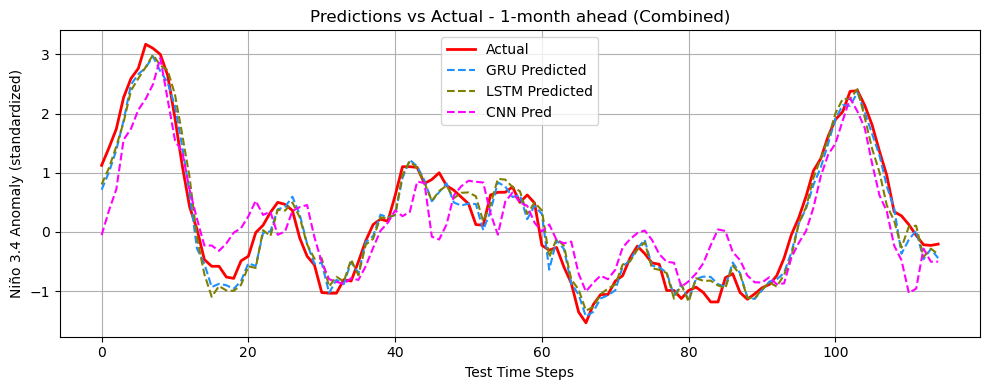

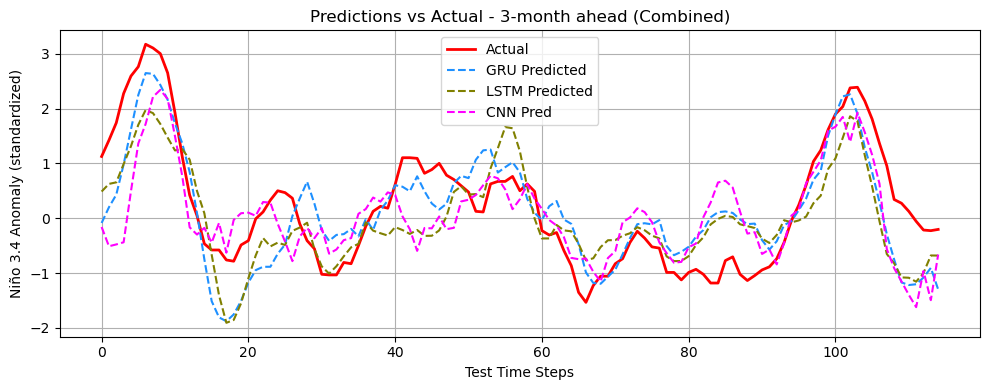

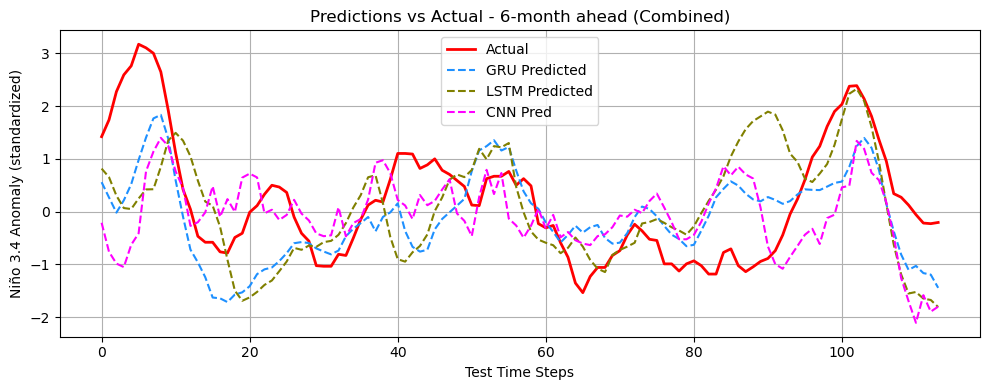

In [20]:
for horizon in horizons:
    actuals, preds_gru, preds_lstm, preds_cnn = gru_lstm_cnn_preds[horizon]

    plt.figure(figsize=(10,4))
    plt.plot(actuals, label='Actual', linewidth=2, color='red')
    plt.plot(preds_gru, label='GRU Predicted', linestyle='--', color='dodgerblue')
    plt.plot(preds_lstm, label='LSTM Predicted', linestyle='--', color='olive')
    plt.plot(preds_cnn, label='CNN Pred', linestyle='--', color='magenta')
    plt.title(f'Predictions vs Actual - {horizon}-month ahead (Combined)')
    plt.xlabel('Test Time Steps')
    plt.ylabel('Niño 3.4 Anomaly (standardized)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

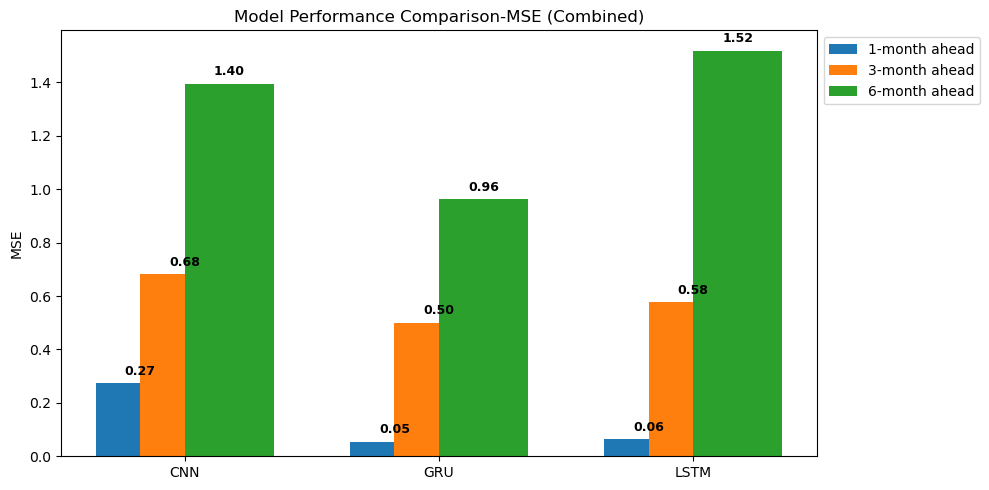


Forecast Horizon: 1 month(s)
  CNN: 0.2742
  GRU: 0.0542
  LSTM: 0.0637

Forecast Horizon: 3 month(s)
  CNN: 0.6822
  GRU: 0.5008
  LSTM: 0.5778

Forecast Horizon: 6 month(s)
  CNN: 1.3952
  GRU: 0.9635
  LSTM: 1.5187


In [21]:
models = list(all_mse[1].keys())

mse_1 = [all_mse[1][m] for m in models]
#mse_1_f = ["{:.2f}".format(x) for x in mse_1]
mse_6 = [all_mse[6][m] for m in models]
# mse_6_f = ["{:.2f}".format(x) for x in mse_6]
mse_3 = [all_mse[3][m] for m in models]
# mse_3_f = ["{:.2f}".format(x) for x in mse_3]

categories = models
bar_width = 0.35
x = np.arange(len(models))


# plt.figure(figsize=(25,10))
fig, ax = plt.subplots(figsize=(10, 5))
bar1 = ax.bar(x - bar_width/2, mse_1, bar_width, label='1-month ahead')
#plt.bar(x - bar_width/2, mse_1, bar_width, label='1-month ahead')
bar2 = ax.bar(x, mse_3, bar_width, label='3-month ahead')
#plt.bar(x, mse_3, bar_width, label='3-month ahead')
bar3 = ax.bar(x + bar_width/2, mse_6, bar_width, label='6-month ahead')
#plt.bar(x + bar_width/2, mse_6, bar_width, label='6-month ahead')

# ___________________________
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,
                         height + 0.02,            # add a small offset above the bar
                         f'{height:.2f}',
                         ha='center', va='bottom',
                         fontsize=9, fontweight='bold')

# ____________________________

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)


ax.set_ylabel('MSE')
ax.set_title('Model Performance Comparison-MSE (Combined)')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


# plt.xticks(x, models)
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

for h in horizons:
    print(f"\nForecast Horizon: {h} month(s)")
    for m, val in all_mse[h].items():
        print(f"  {m}: {val:.4f}")